In [1]:
import pandas as pd 
import numpy as np 
import pymc3 as pm

from matplotlib import pyplot as plt
import seaborn as sns 

%matplotlib inline
sns.set_theme()
import warnings
warnings.filterwarnings('ignore')

# Noodle Analysis 

## google trend of the most exquisite oriental food

https://trends.google.com/trends/explore?date=all&q=%2Fm%2F02y17j,%2Fm%2F09gms,%2Fm%2F012y1_

In [2]:
df = pd.read_csv('multiTimeline.csv')
df = df[(df.Month > '2015-05' )& (df.Month < '2017-05')]

In [3]:
df.head()

,Month,Pho,Ramen,Soba
137,2015-06,16,15,4
138,2015-07,18,17,4
139,2015-08,18,17,4
140,2015-09,18,16,4
141,2015-10,18,16,4


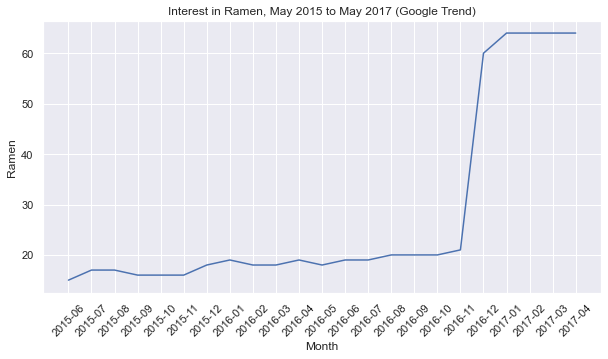

In [4]:
plt.figure(figsize=(10,5))
ax = sns.lineplot(x='Month',y='Ramen',data=df)
ax.tick_params(axis='x', rotation=45)
ax.set_title("Interest in Ramen, May 2015 to May 2017 (Google Trend)");

## The model for the surge
    - In order to model the sudden change in taste of noodle, we'll use a sigmoid function
    - parameter for this functions will be infered with Monte Carlo methods

In [5]:
def sigmoid(x,loc=0,scale=1,slope=1):
    x = x-loc
    return scale / ( 1 + np.exp(-x * slope))

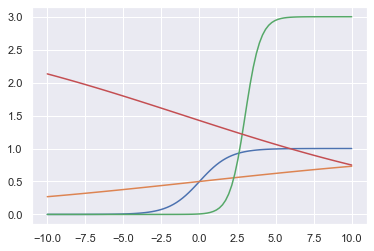

In [6]:
x = np.linspace(-10,10,100)
sns.lineplot(x,sigmoid(x));
sns.lineplot(x,sigmoid(x,slope=0.1));
sns.lineplot(x,sigmoid(x,loc=3,slope=2,scale=3));
sns.lineplot(x,sigmoid(x,loc=-1,slope=-0.1,scale=3));

## Model fitting

In [7]:
df = df.sort_values('Month',ascending=True)
df['x'] = np.arange(len(df))

In [8]:
with pm.Model() as noodle_model:
    β_0 = pm.Normal('β_0',mu=0,sd=1)
    β = pm.Normal('β',mu=0,sd=1)
    
    trend = β_0 + β * df.x
    
    loc = pm.Uniform('loc',df.x.min(),df.x.max())
    scale = pm.Exponential('scale',1)
    slope = pm.HalfNormal('slope',1)#I can see it's a positive surge
    surge = sigmoid(df.x.values,loc,scale,slope)
    
    μ = trend + surge
    
    likelihood = pm.Normal('lkl',mu=μ,sd=1,observed = df.Ramen.values)
    
    trace = pm.sample(2000,tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [slope, scale, loc, β, β_0]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 15 seconds.


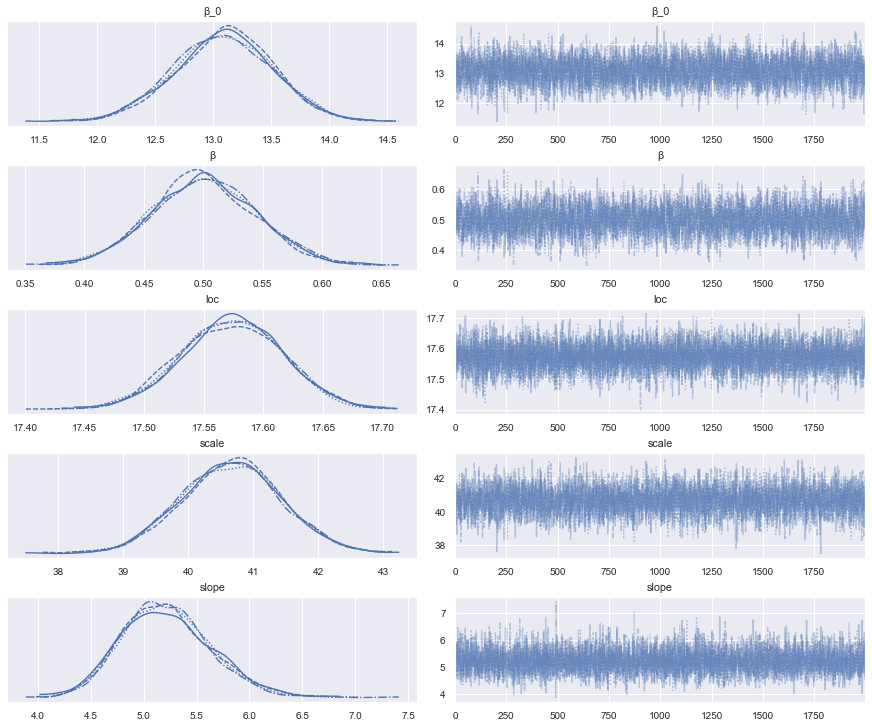

In [9]:
pm.plot_trace(trace);

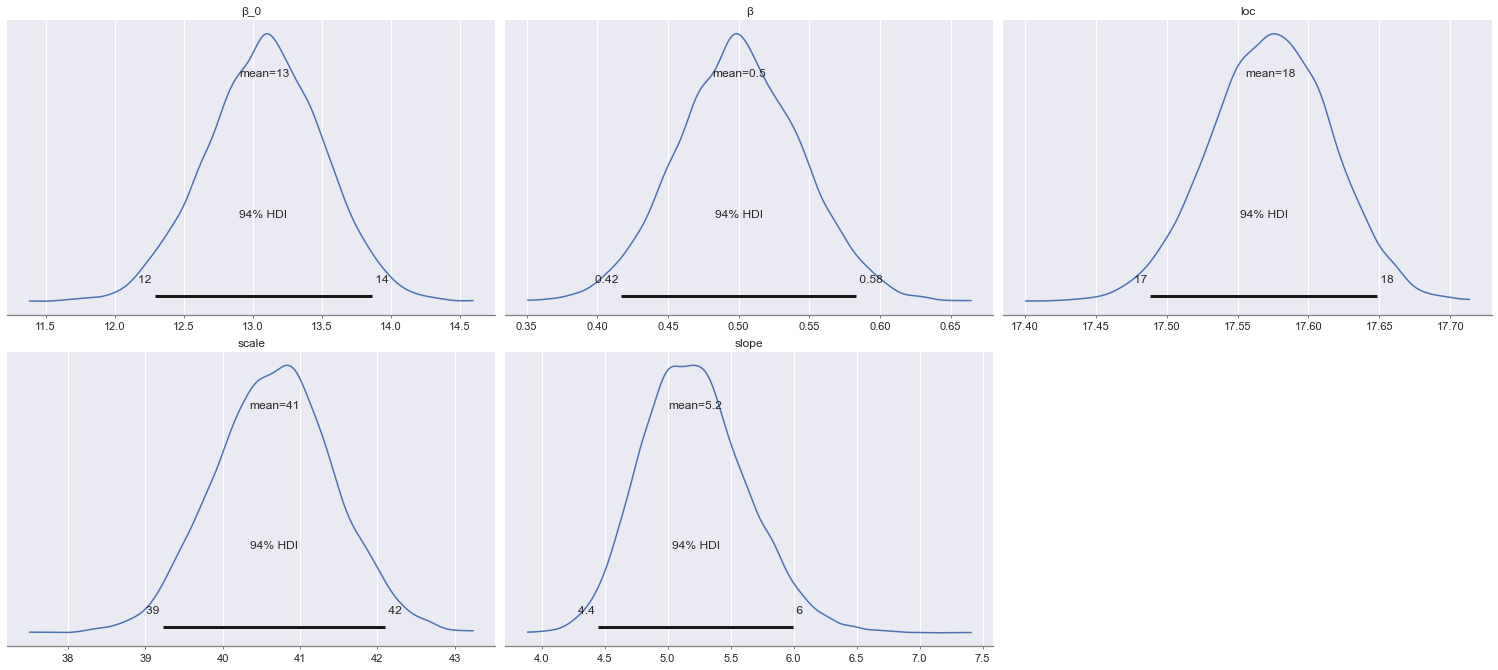

In [10]:
pm.plot_posterior(trace);

In [11]:
pm.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β_0,13.087,0.420,12.291,13.867,0.006,0.005,4334.0,5245.0,1.0
β,0.501,0.044,0.417,0.583,0.001,0.001,3675.0,4781.0,1.0
loc,17.573,0.043,17.489,17.648,0.001,0.000,7251.0,5692.0,1.0
scale,40.663,0.772,39.227,42.097,0.012,0.008,4257.0,5247.0,1.0
slope,5.215,0.419,4.448,5.995,0.005,0.004,6641.0,5680.0,1.0


## Posterior predictive (PP) check

In [12]:
def line(x,trace,f=np.mean):
    var  = ['β_0', 'β', 'loc', 'scale', 'slope']
    β_0, β, loc, scale, slope = [f(trace[v]) for v in var]
    return β_0 + β * x + sigmoid(x,loc,scale,slope)
    

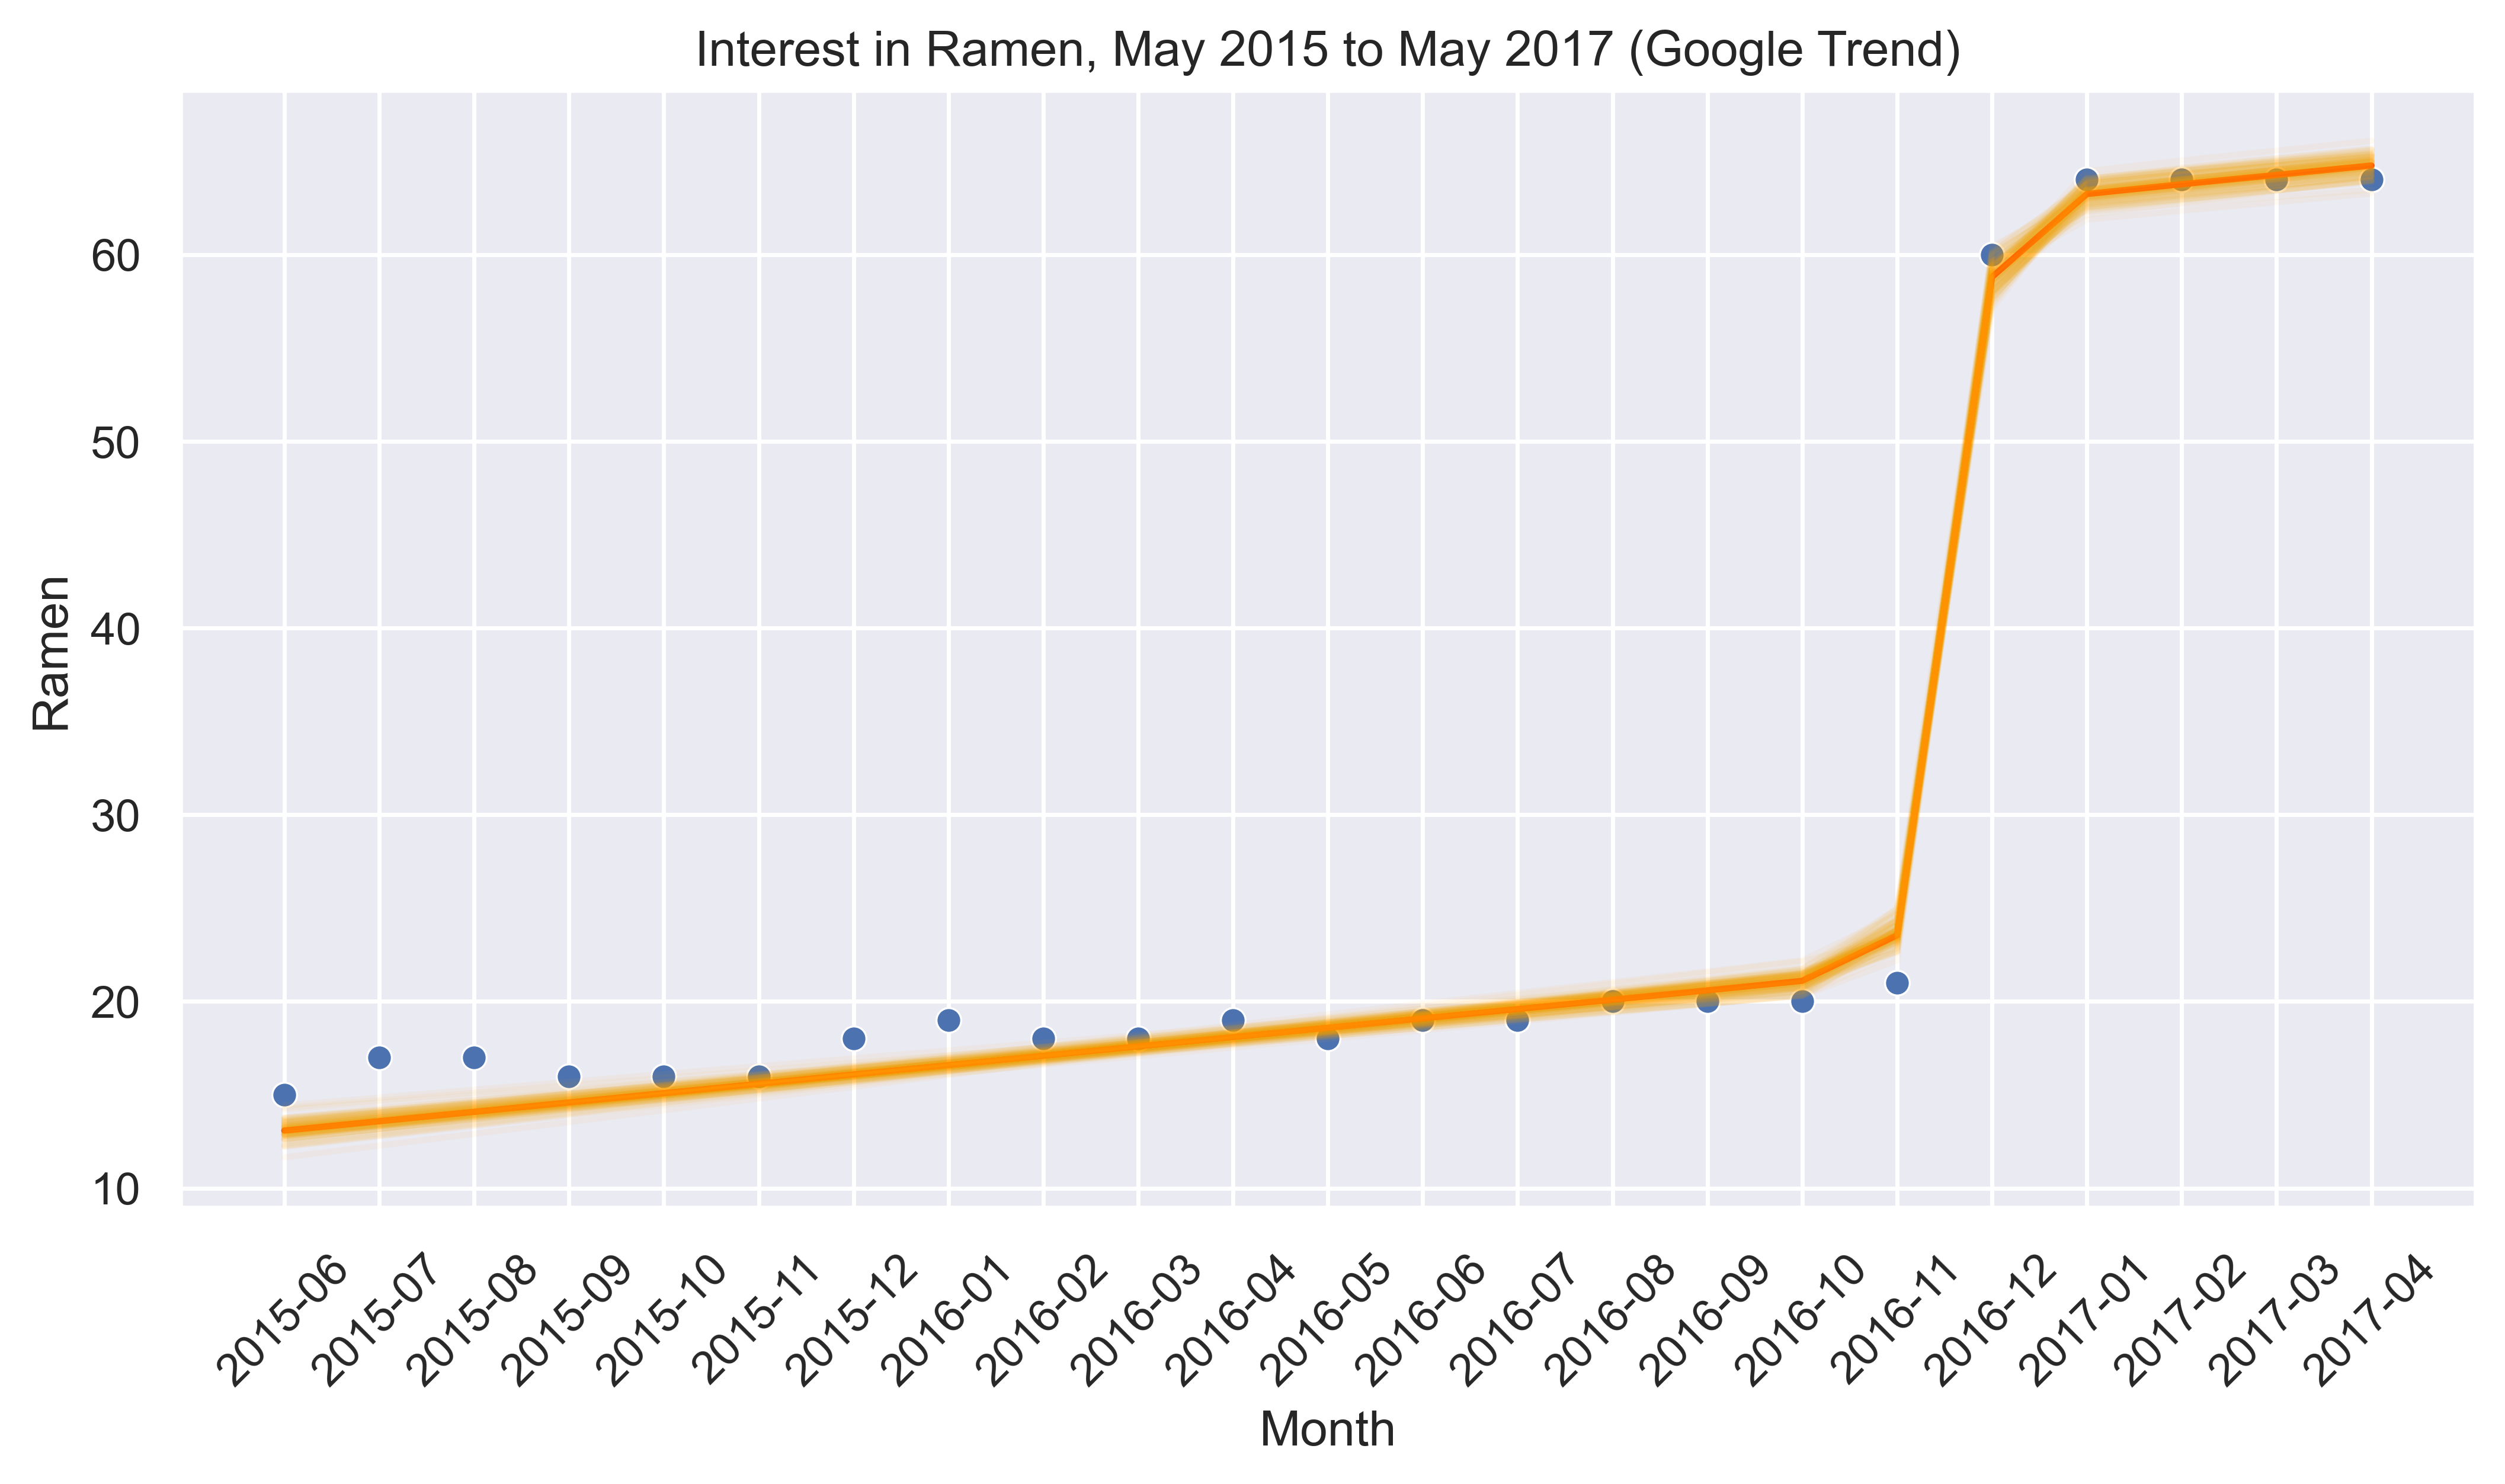

In [13]:

plt.figure(figsize=(10,5),dpi=500)

ax = sns.scatterplot(x='Month',y='Ramen',data=df)
ax.tick_params(axis='x', rotation=45)

sns.lineplot(df.x.values, line(df.x.values,trace),color='red')
ax.set_title("Interest in Ramen, May 2015 to May 2017 (Google Trend)");


for l in range(1,100):
    sns.lineplot(df.x.values, line(df.x.values,trace,f=lambda arr: arr[-l]),color='orange',alpha=0.05)


# Multiple surge and dip
- Let's recover the parameter from a synthetic dataset

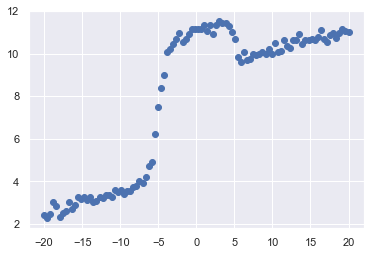

In [14]:
x = np.linspace(-20,20,100)
b0,b = 2.5, 0.1

loc1, scale1, slope1 = -5,6.6,1.5
loc2, scale2, slope2 = 5,2,-5
noise = np.random.normal(loc=0,scale=.15,size=len(x))
y = b0 + b*x + sigmoid(x,loc1,scale1,slope1) + sigmoid(x,loc2,scale2,slope2) + noise
plt.scatter(x,y)


In [15]:
with pm.Model() as synth_model:
    b0 = pm.Normal('b0',mu=0,sd=1)
    b = pm.Normal('b',mu=0,sd=1)
    
    trend = b0 + b * x
    
    loc1 = pm.Uniform('loc1',x.min(), x.max())
    scale1 = pm.Exponential('scale1',1)
    slope1 = pm.HalfNormal('slope1',sd=1)
    surge = sigmoid(x, loc1, scale1, slope1)
    
    loc2 = pm.Uniform('loc2',loc1, x.max())
    scale2 = pm.Exponential('scale2',1)
    slope2 = -pm.HalfNormal('slope2',sd=2)
    dip = sigmoid(x, loc2, scale2, slope2) #the dip
    
#     constraint = pm.Potential('order', pm.math.switch( loc1 < loc2, 0, -np.inf))
    μ = trend + surge + dip
    
    σ = pm.HalfNormal('σ',1)
    likelihood = pm.Normal('lkl',mu=μ,sd=σ,observed = y)
    
    trace = pm.sample(2000,tune=2000,target_accept=0.8)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, slope2, scale2, loc2, slope1, scale1, loc1, b, b0]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 20 seconds.


In [16]:
pm.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b0,2.601,0.064,2.482,2.721,0.001,0.001,6313.0,5402.0,1.0
b,0.099,0.005,0.089,0.110,0.000,0.000,3970.0,4549.0,1.0
loc1,-5.040,0.037,-5.108,-4.971,0.000,0.000,7955.0,5586.0,1.0
scale1,6.567,0.097,6.396,6.759,0.002,0.001,4080.0,4578.0,1.0
slope1,1.666,0.094,1.501,1.852,0.001,0.001,6209.0,5655.0,1.0
loc2,4.986,0.083,4.828,5.134,0.001,0.001,8558.0,5582.0,1.0
scale2,1.893,0.087,1.722,2.052,0.001,0.001,4411.0,4872.0,1.0
slope2,3.543,0.776,2.261,5.048,0.009,0.007,7318.0,5197.0,1.0
σ,0.180,0.013,0.155,0.205,0.000,0.000,7848.0,4992.0,1.0


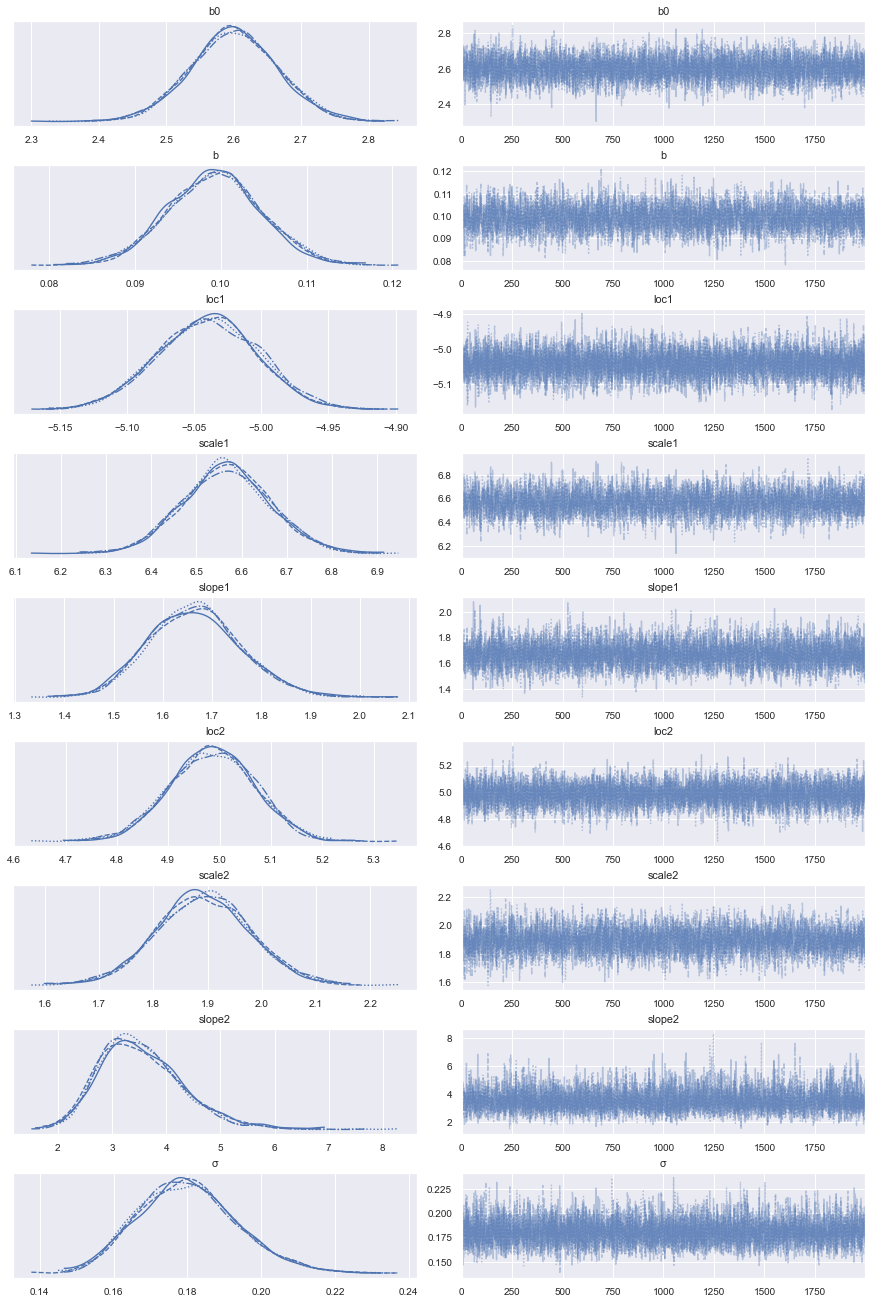

In [17]:
pm.plot_trace(trace);

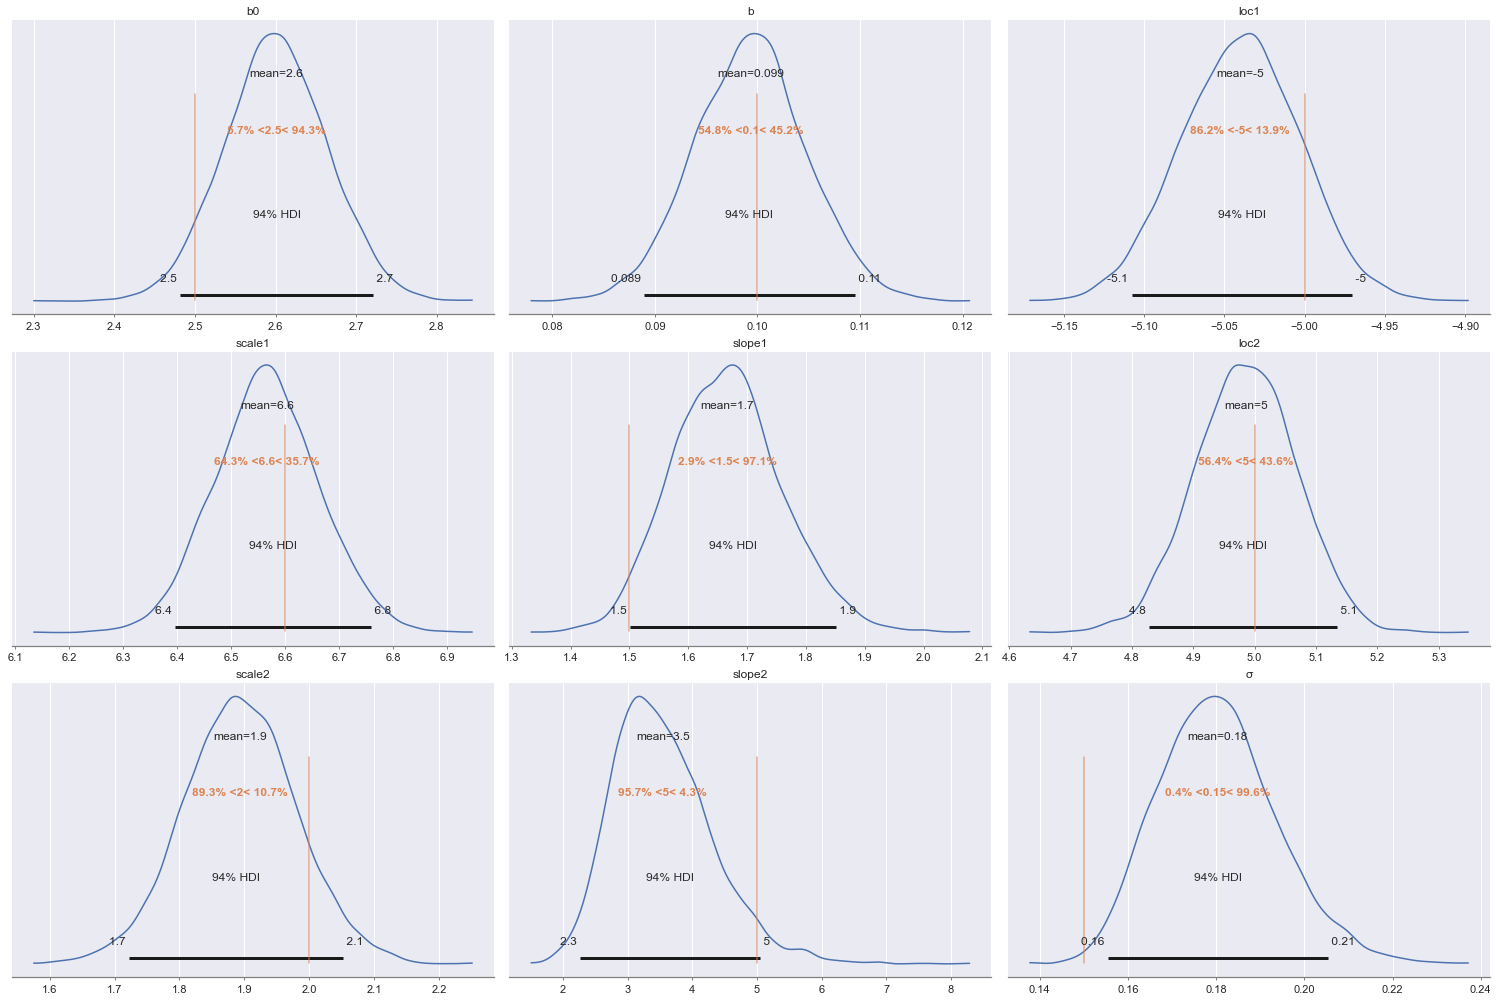

In [18]:

pm.plot_posterior(trace,
                  var_names=['b0','b','loc1','scale1','slope1','loc2','scale2','slope2','σ'],
                  ref_val=[2.5,0.1,-5,6.6,1.5,5,2,5,0.15]
                 );

In [19]:
def line(x,trace=trace,f=np.mean):
    var  = ['b0','b','loc1','scale1','slope1','loc2','scale2','slope2']
    b0, b, loc1, scale1, slope1, loc2, scale2, slope2 = [f(trace[v]) for v in var]
    return b0 + b * x + sigmoid(x,loc1,scale1,slope1) + sigmoid(x,loc2,scale2,-slope2)
    

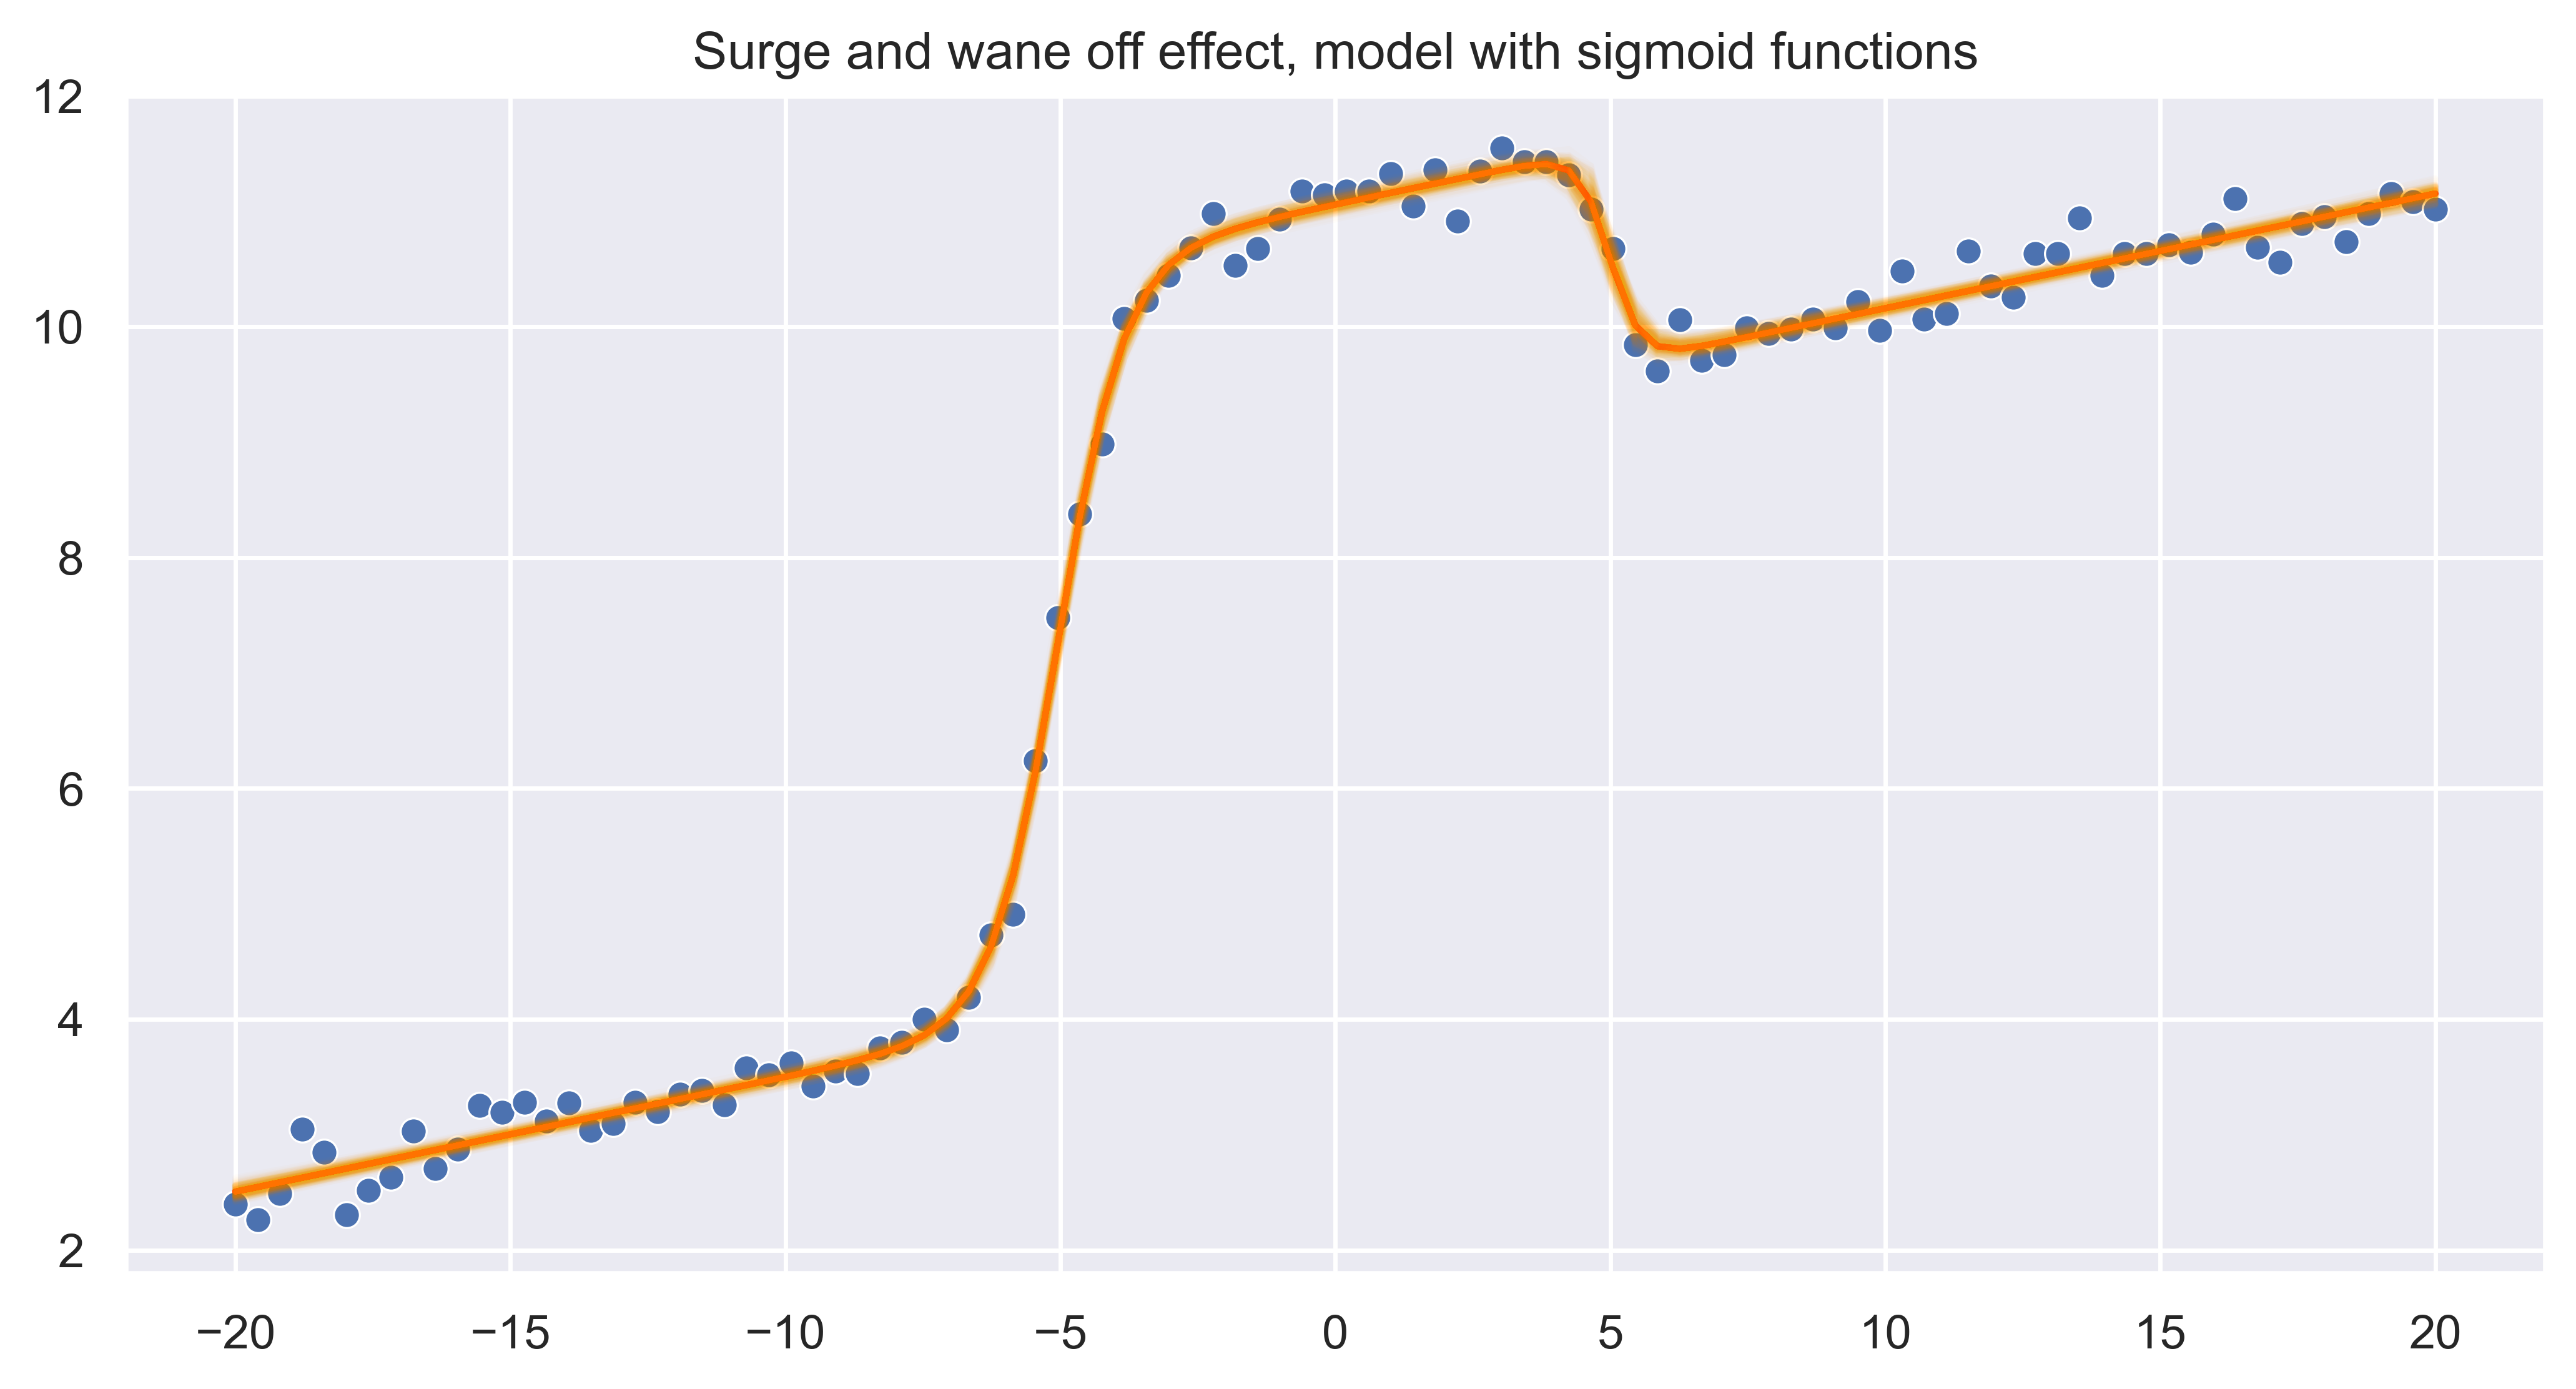

In [20]:

plt.figure(figsize=(10,5),dpi=500)

ax = sns.scatterplot(x,y)

sns.lineplot(x, line(x),color='red')

for l in range(1,200):
    sns.lineplot(x, line(x,f=lambda arr: arr[-l]),color='orange',alpha=0.02)

ax.set_title("Surge and wane off effect, model with sigmoid functions");    

From this model, we can do inference like what's the growth rate at the middle of the surge, the scale of the surge and so on

In [21]:
delta = 1e-5
grad = (line(-5+delta,trace) - line(-5-delta,trace)) / (2*delta)

print(grad)

2.8313942012303523
